# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/datasets/ealaxi/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/elsonluis/Downloads/PS_20174392719_1491204439457_log.csv')

df_sample = df.sample(n=100000, random_state=1)


### What is the distribution of the outcome? 

isFraud
0    99876
1      124
Name: count, dtype: int64


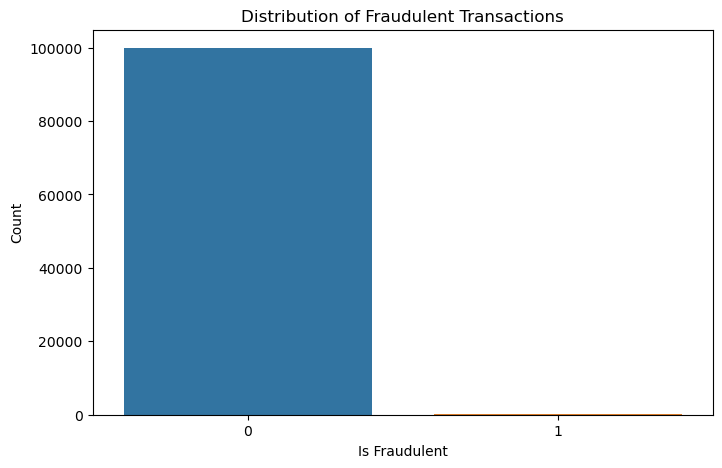

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fraud_distribution = df_sample['isFraud'].value_counts()

print(fraud_distribution)

plt.figure(figsize=(8, 5))
sns.countplot(x='isFraud', data=df_sample)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraudulent')
plt.ylabel('Count')
plt.show()


### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [9]:
print(df_sample.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [10]:
import numpy as np

df_sample['step_sin'] = np.sin(2 * np.pi * df_sample['step'] / 24)
df_sample['step_cos'] = np.cos(2 * np.pi * df_sample['step'] / 24)


In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Run a logisitc regression classifier and evaluate its accuracy.

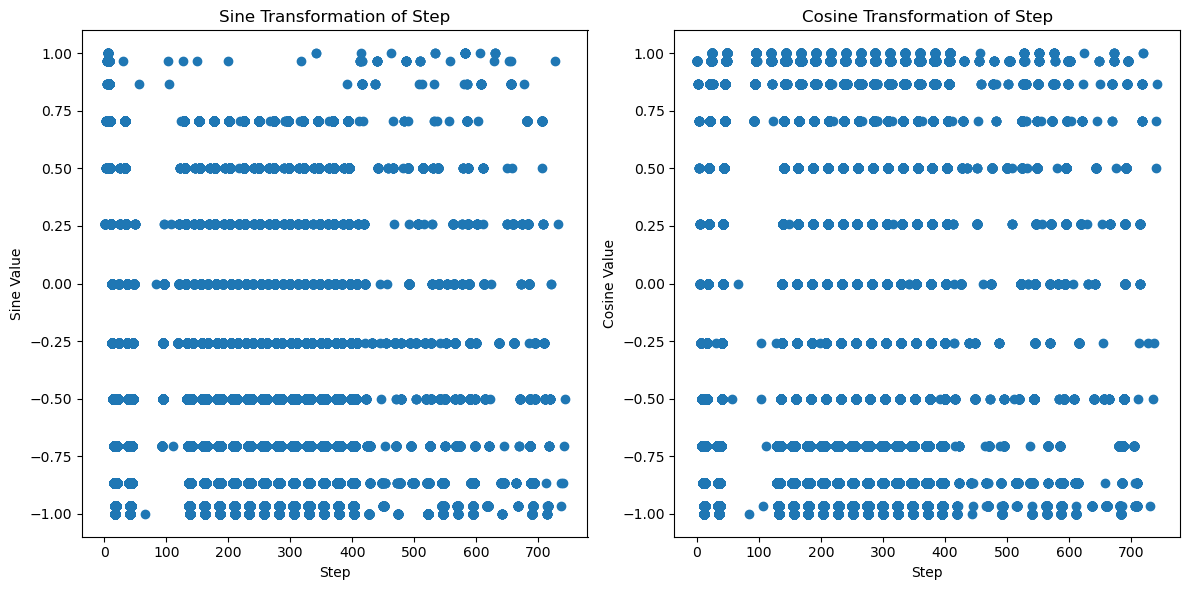

In [12]:
df_sample['step_sin'] = np.sin(2 * np.pi * df_sample['step'] / 24)
df_sample['step_cos'] = np.cos(2 * np.pi * df_sample['step'] / 24)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_sample['step'], df_sample['step_sin'])
plt.title('Sine Transformation of Step')
plt.xlabel('Step')
plt.ylabel('Sine Value')

plt.subplot(1, 2, 2)
plt.scatter(df_sample['step'], df_sample['step_cos'])
plt.title('Cosine Transformation of Step')
plt.xlabel('Step')
plt.ylabel('Cosine Value')

plt.tight_layout()
plt.show()


### Now pick a model of your choice and evaluate its accuracy.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder


onehot_encoder = OneHotEncoder()
categorical_columns = ["Replecedd"]  
encoded_categorical = onehot_encoder.fit_transform(df_sample[categorical_columns]).toarray()

KeyError: "None of [Index(['Replecedd'], dtype='object')] are in the [columns]"

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_sample.drop('isFraud', axis=1)  
y = df_sample['isFraud']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


ValueError: could not convert string to float: 'CASH_IN'

### Which model worked better and how do you know?

In [2]:
# Your response here

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.